In [1]:
# Import the standard modules
import sqlite3
import spiceypy

# Import the installed modules
import pandas as pd
import numpy as np

# Import matplotlib for plotting
from matplotlib import pyplot as plt

# Import scipy for the Kernel Density Estimator functionality
from scipy import stats

In [2]:
# Connect to the comet database. This database has been created in tutorial
# part 7, however, due to its small size the database is uploaded on GitHub
con = sqlite3.connect('../_databases/_comets/mpc_comets.db')

# Set a cursor
cur = con.cursor()

# Create a pandas dataframe that contains the name of the comet (needed later),
# the semi-major axis, inclination and eccentricity
# for P type ...
P_TYPE_DF = pd.read_sql('SELECT NAME, SEMI_MAJOR_AXIS_AU, INCLINATION_DEG, ' \
                        'ECCENTRICITY FROM comets_main WHERE ORBIT_TYPE="P"', \
                        con)

# ... and C type comets. For this type: set the eccentricity smaller 1 (bound
# orbits)
C_TYPE_DF = pd.read_sql('SELECT NAME, SEMI_MAJOR_AXIS_AU, INCLINATION_DEG, ' \
                        'ECCENTRICITY FROM comets_main WHERE ORBIT_TYPE="C" ' \
                        'AND ECCENTRICITY<1', con)

In [3]:
# The Tisserand parameter will help us to distinguish between Jupiter Family
# Comets (JFCs) and Non-JFCss more easily. For this parameter (next block) we
# need the semi-major axis of Jupiter

# Import a kernel meta file
spiceypy.furnsh('kernel_meta.txt')

# Set any Ephemeris time (ET)
SAMPLE_ET = spiceypy.utc2et('2000-001T00:00:00')

# Compute the state vector of Jupiter in ECLIPJ2000 (Jupiter (599) is not
# available in the kernel, we use the barycentre (5))
STATE_VEC_JUPITER, _ = spiceypy.spkgeo(targ=5, \
                                       et=SAMPLE_ET, \
                                       ref='ECLIPJ2000', \
                                       obs=10)

# Get the G*M value of the Sun
_, GM_SUN_PRE = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN_PRE[0]

# Compute the orbital elements of Jupiter
ORB_ELEM_JUPITER = spiceypy.oscltx(STATE_VEC_JUPITER, SAMPLE_ET, GM_SUN)

# Get the semi-major axis value
A_JUPITER_KM = ORB_ELEM_JUPITER[-2]

# Convert the value from km to AU
A_JUPITER_AU = spiceypy.convrt(A_JUPITER_KM, 'km', 'AU')

In [4]:
# Define a lambda function for the Tisserand parameter, a, i and e are the
# input parameters semi-major axis, inclination and eccentricity, respectively
tisr_jup = lambda a, i, e: (A_JUPITER_AU / a) + 2 * np.cos(i) \
                           * np.sqrt((a / A_JUPITER_AU) * (1 - (e**2.0)))

# Create a new dataframe columns that contains the Tisserand parameter
P_TYPE_DF.loc[:, 'TISSERAND_JUP'] = \
    P_TYPE_DF.apply(lambda x: (tisr_jup(a=x['SEMI_MAJOR_AXIS_AU'], \
                                        i=np.radians(x['INCLINATION_DEG']), \
                                        e=x['ECCENTRICITY'])), axis=1)

C_TYPE_DF.loc[:, 'TISSERAND_JUP'] = \
    C_TYPE_DF.apply(lambda x: (tisr_jup(a=x['SEMI_MAJOR_AXIS_AU'], \
                               i=np.radians(x['INCLINATION_DEG']), \
                               e=x['ECCENTRICITY'])), axis=1)

In [5]:
# Print some descriptive statistics of the P type comets
print('Descriptive statistics of the Tisserand parameter of P type comets')
print(f'{P_TYPE_DF["TISSERAND_JUP"].describe()}')
print('\n')

# Compute the percentage of Jupiter-Family Comets (JFCs) based on P types
PERC_P_TYPE_JFCS = len(P_TYPE_DF.loc[(P_TYPE_DF["TISSERAND_JUP"] > 2) \
                                      & (P_TYPE_DF["TISSERAND_JUP"] < 3)]) \
                    / len(P_TYPE_DF.index) * 100
PERC_P_TYPE_JFCS = round(PERC_P_TYPE_JFCS, 0)

# Print how many P comets have a Tisserand parameter between 2 and 3:
print('Percentage of P type comets with a Tisserand parameter between ' \
      f'2 and 3: {PERC_P_TYPE_JFCS}%')
print('\n')

# Print some descriptive statistics of the C type comets
print('Descriptive statistics of the Tisserand parameter of C type comets')
print(f'{C_TYPE_DF["TISSERAND_JUP"].describe()}')
print('\n')

Descriptive statistics of the Tisserand parameter of P type comets
count    627.000000
mean       2.672696
std        0.555275
min       -0.648993
25%        2.610908
50%        2.805879
75%        2.935148
max        3.663401
Name: TISSERAND_JUP, dtype: float64


Percentage of P type comets with a Tisserand parameter between 2 and 3: 83.0%


Descriptive statistics of the Tisserand parameter of C type comets
count    159.000000
mean       0.535408
std        1.365811
min       -2.758114
25%       -0.412254
50%        0.548308
75%        1.357792
max        3.578201
Name: TISSERAND_JUP, dtype: float64




In [6]:
# We define a function to add a new column in an already existing database
# table. This code snippet may be helpful in the future
def add_col2tab(con_db, cur_db, tab_name, col_name, col_type):
    """
    This function adds a new column to an already existing SQLite table.
    Setting a new or editing an existing key (primary or foreign) is not
    possible.

    Parameters
    ----------
    con_db : sqlite3.Connection
        Connection object to the SQLite database.
    cur_db : sqlite3.Cursor
        Connection corresponding cursor.
    tab_name : str
        Table name.
    col_name : str
        New column name that shall be added.
    col_type : str
        New column name corresponding SQLite column type.

    Returns
    -------
    None.

    """

    # Iterate through all existing column names of the database table using
    # the PRAGMA table_info command
    for row in cur_db.execute(f'PRAGMA table_info({tab_name})'):

        # If the column exists: exit the function
        if row[1] == col_name:
            break

    # If the column is not existing yet, add the new column
    else:
        cur_db.execute(f'ALTER TABLE {tab_name} ' \
                       f'ADD COLUMN {col_name} {col_type}')
        con_db.commit()

# Add a new column in the comets_main table for the Tisserand parameters
add_col2tab(con_db=con, \
            cur_db=cur, \
            tab_name='comets_main', \
            col_name='TISSERAND_JUP', \
            col_type='REAL')

In [7]:
# Add the Tisserand parameter results to the database
cur.executemany('UPDATE comets_main SET TISSERAND_JUP=? WHERE NAME=?', \
                P_TYPE_DF[['TISSERAND_JUP', 'NAME']].values)
con.commit()

cur.executemany('UPDATE comets_main SET TISSERAND_JUP=? WHERE NAME=?', \
                C_TYPE_DF[['TISSERAND_JUP', 'NAME']].values)
con.commit()

In [8]:
# Compute the KDE distribution for the Tisserand values, ranging from -1 to
# 5
TISSERAND_RANGE = np.linspace(0, 5, 1000)

# Kernel and distribution computation for the P type comets
P_TYPE_TISR_KERNEL = stats.gaussian_kde(P_TYPE_DF['TISSERAND_JUP'])
P_TYPE_TISR_DISTR = P_TYPE_TISR_KERNEL(TISSERAND_RANGE)

# Kernel and distribution computation for the C type comets
C_TYPE_TISR_KERNEL = stats.gaussian_kde(C_TYPE_DF['TISSERAND_JUP'])
C_TYPE_TISR_DISTR = C_TYPE_TISR_KERNEL(TISSERAND_RANGE)

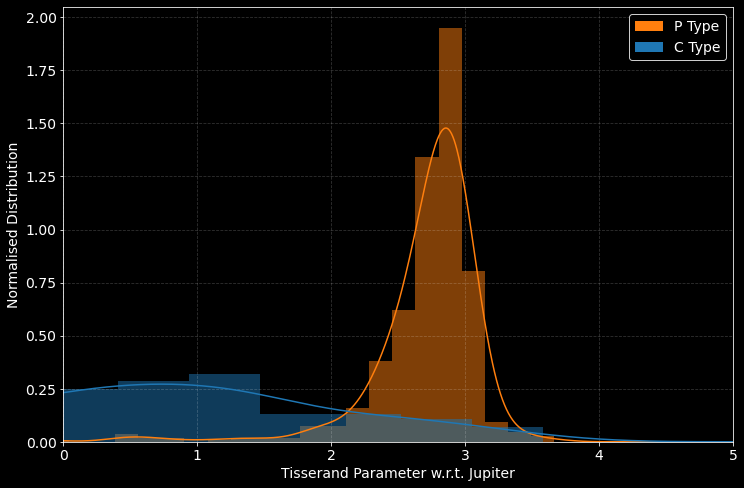

In [9]:
# Square-root choice for the histograms number of bins
nr_of_bins = lambda data_array: int(np.floor(np.sqrt(len(data_array))))

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Histogram of the P and C type comets' Tisserand parameter.
ax.hist(P_TYPE_DF['TISSERAND_JUP'], \
        bins=nr_of_bins(P_TYPE_DF['TISSERAND_JUP']), \
        density=True, color='tab:orange', alpha=0.5, label='P Type')

ax.hist(C_TYPE_DF['TISSERAND_JUP'], \
        bins=nr_of_bins(C_TYPE_DF['TISSERAND_JUP']), \
        density=True, color='tab:blue', alpha=0.5, label='C Type')

# Plot the KDE of the P type comets
ax.plot(TISSERAND_RANGE, P_TYPE_TISR_DISTR, color='tab:orange', alpha=1, linestyle='solid')

# Plot the KDE of the C type comets
ax.plot(TISSERAND_RANGE, C_TYPE_TISR_DISTR, color='tab:blue', alpha=1, linestyle='solid')

# Set an x axis limits
ax.set_xlim(0, 5)

# Add a grid for better readability
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Set an x and y label
ax.set_xlabel('Tisserand Parameter w.r.t. Jupiter')
ax.set_ylabel('Normalised Distribution')

# Re-define the opacity (alpha value) of the markers / lines in the
# legend for better visibility
leg = ax.legend(fancybox=True, loc='upper right', framealpha=1)
for lh in leg.legendHandles:
    lh.set_alpha(1)

# Save the figure
plt.savefig('comets_kde_tisserand_jup.png', dpi=300)